# Building a CNN with claude for CNN final deep learning

## imports and GPU check

In [4]:
!ls

augmented.keras  model_best.keras   residual.keras		    test
batch.keras	 model.png	    res-net.keras		    train
model_best.h5	 regularized.keras  res-net-trainable-layers.keras  validation


In [6]:
%cd ../

/content/drive/MyDrive/data


## Environment Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Check for GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## Dataset Exploration

In [7]:
# Define the base directory
base_dir = "split_clash"

# Display the directory structure
print("Dataset structure:")
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    print(f"\n{split} directory:")
    classes = os.listdir(split_dir)
    print(f"Classes: {classes}")

    for cls in classes:
        class_dir = os.path.join(split_dir, cls)
        num_images = len(os.listdir(class_dir))
        print(f"  - {cls}: {num_images} images")

# Count total images
total_images = 0
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    for cls in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, cls)
        total_images += len(os.listdir(class_dir))

print(f"\nTotal images in dataset: {total_images}")

Dataset structure:

train directory:
Classes: ['th_13', 'th_14', 'th_11', 'th_17', 'th_15', 'th_12', 'th_16', 'th_10']
  - th_13: 90 images
  - th_14: 90 images
  - th_11: 90 images
  - th_17: 93 images
  - th_15: 98 images
  - th_12: 90 images
  - th_16: 81 images
  - th_10: 90 images

validation directory:
Classes: ['th_13', 'th_15', 'th_14', 'th_12', 'th_17', 'th_10', 'th_11', 'th_16']
  - th_13: 20 images
  - th_15: 22 images
  - th_14: 20 images
  - th_12: 20 images
  - th_17: 20 images
  - th_10: 20 images
  - th_11: 20 images
  - th_16: 18 images

test directory:
Classes: ['th_16', 'th_12', 'th_15', 'th_14', 'th_17', 'th_11', 'th_13', 'th_10']
  - th_16: 18 images
  - th_12: 20 images
  - th_15: 22 images
  - th_14: 20 images
  - th_17: 21 images
  - th_11: 20 images
  - th_13: 20 images
  - th_10: 20 images

Total images in dataset: 1043


## Sample Image Visualization

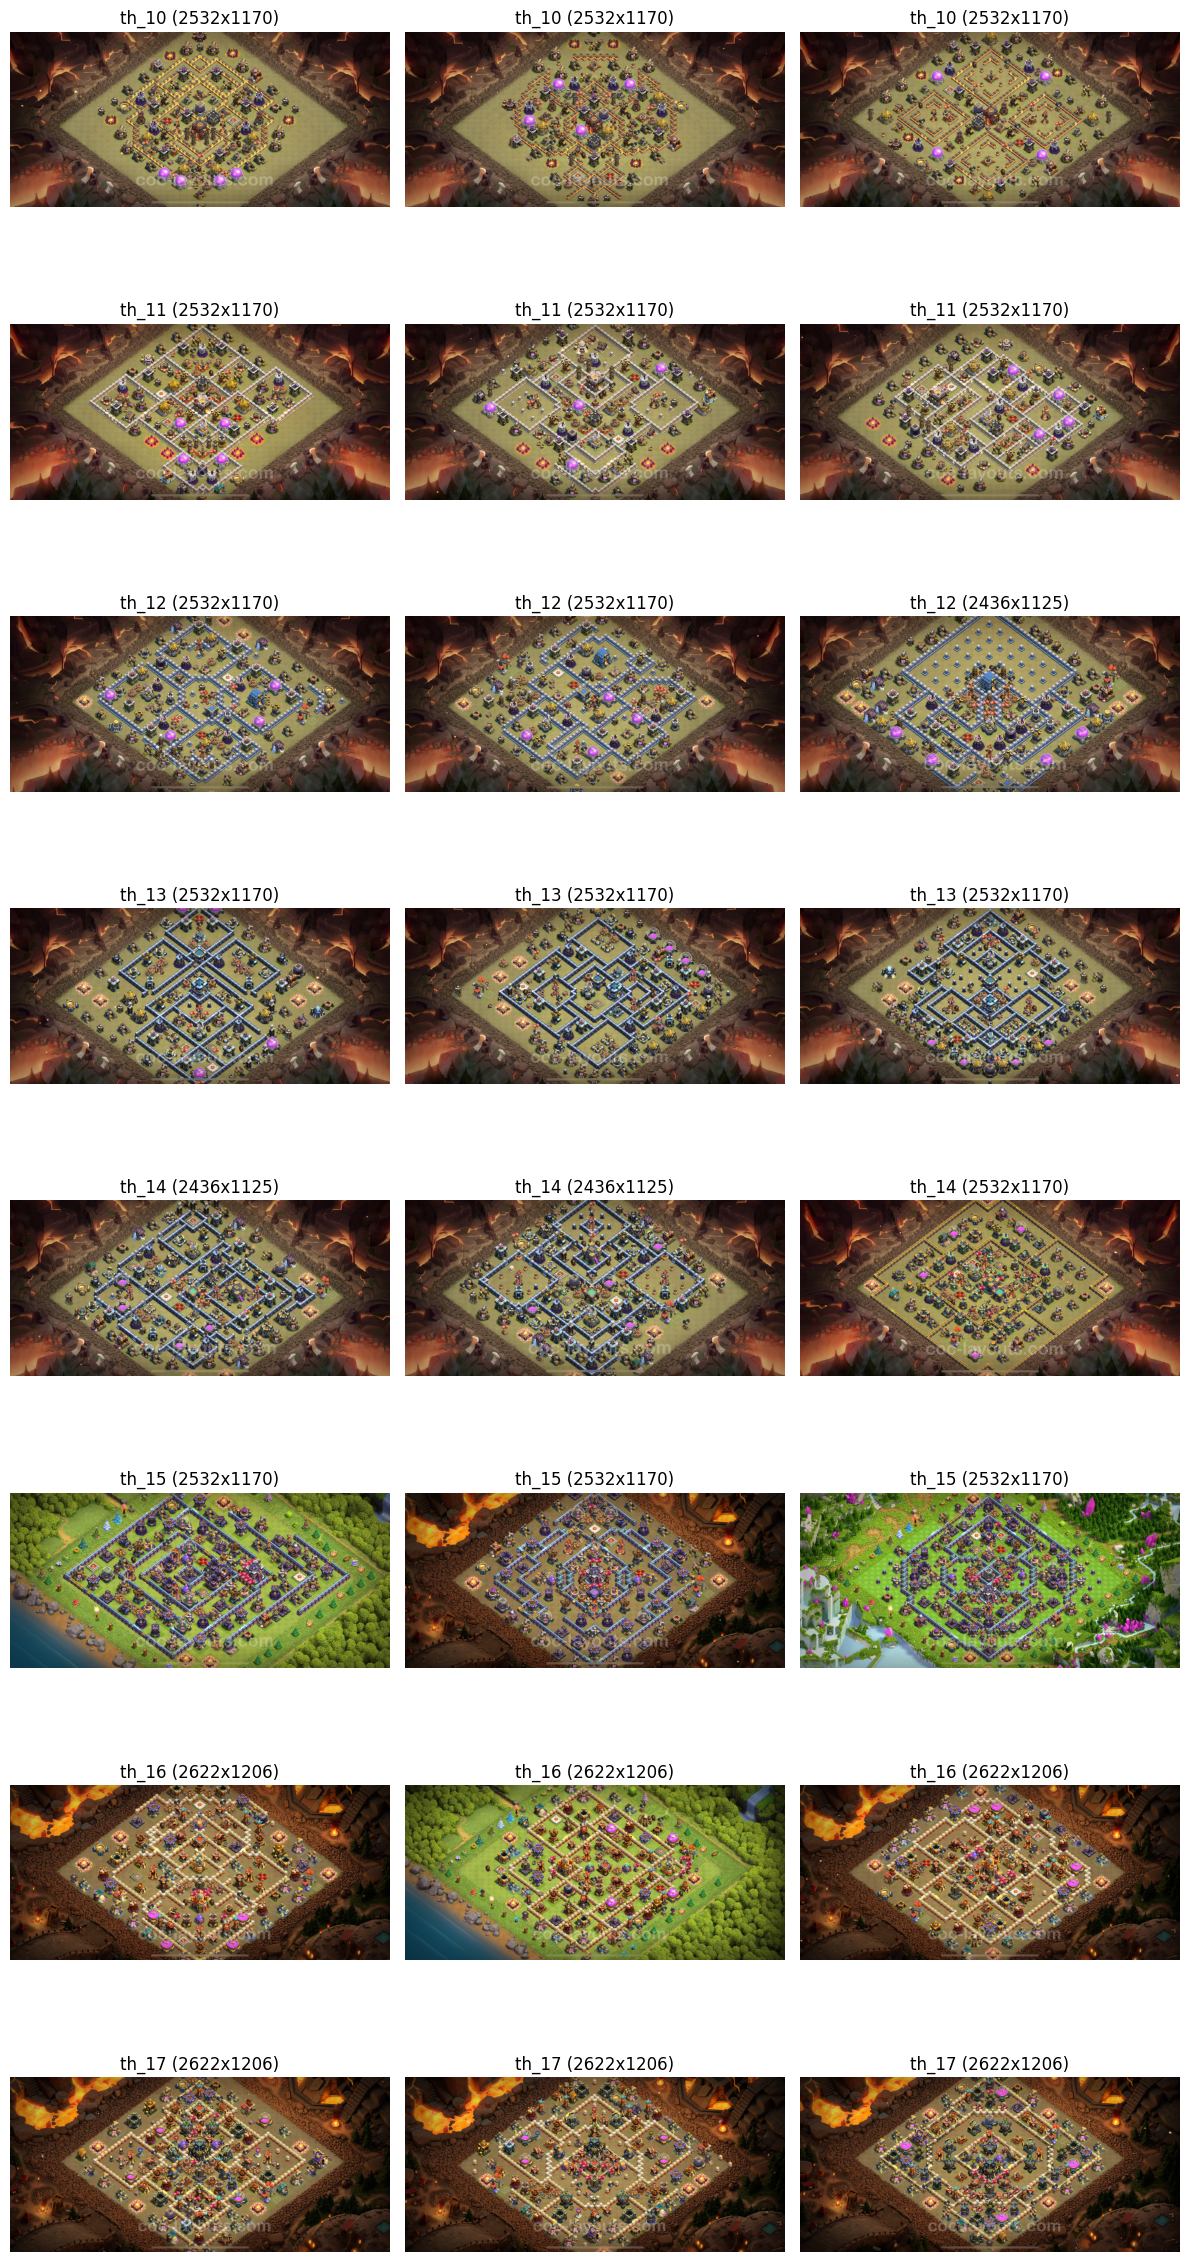

Sample image dimensions: (2532, 1170)


In [8]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and display sample images from each class
def display_sample_images(base_dir, split='train', num_samples=2):
    split_dir = os.path.join(base_dir, split)
    classes = sorted(os.listdir(split_dir))

    # Set up the plot grid
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, 3*len(classes)))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(split_dir, cls)
        image_files = os.listdir(class_dir)

        # Select random samples
        samples = random.sample(image_files, min(num_samples, len(image_files)))

        for j, sample in enumerate(samples):
            img_path = os.path.join(class_dir, sample)
            img = load_img(img_path)

            # Get image dimensions
            width, height = img.size

            # Display image
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{cls} ({width}x{height})")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

    # Return a sample image to determine typical dimensions
    sample_img_path = os.path.join(split_dir, classes[0], os.listdir(os.path.join(split_dir, classes[0]))[0])
    sample_img = load_img(sample_img_path)
    print(f"Sample image dimensions: {sample_img.size}")
    return sample_img.size

# Visualize samples from training set
img_size = display_sample_images(base_dir, 'train', 3)

## Class distribution analysis

Class Distribution:
       train  validation  test  total  train_pct  validation_pct  test_pct
th_10     90          20    20    130      69.23           15.38     15.38
th_11     90          20    20    130      69.23           15.38     15.38
th_12     90          20    20    130      69.23           15.38     15.38
th_13     90          20    20    130      69.23           15.38     15.38
th_14     90          20    20    130      69.23           15.38     15.38
th_15     98          22    22    142      69.01           15.49     15.49
th_16     81          18    18    117      69.23           15.38     15.38
th_17     93          20    21    134      69.40           14.93     15.67


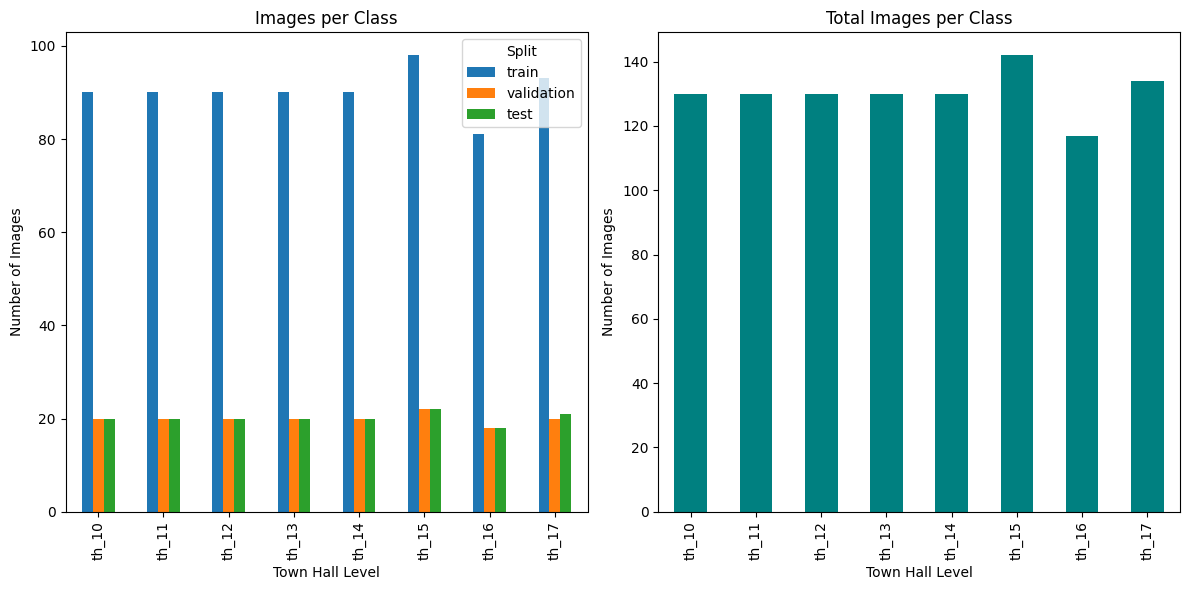

In [9]:
# Analyze class distribution
def analyze_class_distribution(base_dir):
    # Initialize dictionaries to store counts
    distribution = {split: {} for split in ['train', 'validation', 'test']}

    # Count images per class in each split
    for split in ['train', 'validation', 'test']:
        split_dir = os.path.join(base_dir, split)
        classes = sorted(os.listdir(split_dir))

        for cls in classes:
            class_dir = os.path.join(split_dir, cls)
            distribution[split][cls] = len(os.listdir(class_dir))

    # Create a DataFrame for easier visualization
    df_dist = pd.DataFrame(distribution)

    # Calculate total per class
    df_dist['total'] = df_dist.sum(axis=1)

    # Calculate percentage per split
    for split in ['train', 'validation', 'test']:
        df_dist[f'{split}_pct'] = (df_dist[split] / df_dist['total'] * 100).round(2)

    # Display table
    print("Class Distribution:")
    print(df_dist)

    # Plot distribution
    plt.figure(figsize=(12, 6))

    # Plot count per class per split
    ax1 = plt.subplot(1, 2, 1)
    df_dist[['train', 'validation', 'test']].plot(kind='bar', ax=ax1)
    plt.title('Images per Class')
    plt.ylabel('Number of Images')
    plt.xlabel('Town Hall Level')
    plt.legend(title='Split')

    # Plot total distribution
    ax2 = plt.subplot(1, 2, 2)
    df_dist['total'].plot(kind='bar', ax=ax2, color='teal')
    plt.title('Total Images per Class')
    plt.ylabel('Number of Images')
    plt.xlabel('Town Hall Level')

    plt.tight_layout()
    plt.show()

    return df_dist

# Run the analysis
class_dist = analyze_class_distribution(base_dir)

## Image preprocessing

Width - Min: 2436, Max: 2622, Median: 2532.0
Height - Min: 1125, Max: 1206, Median: 1170.0


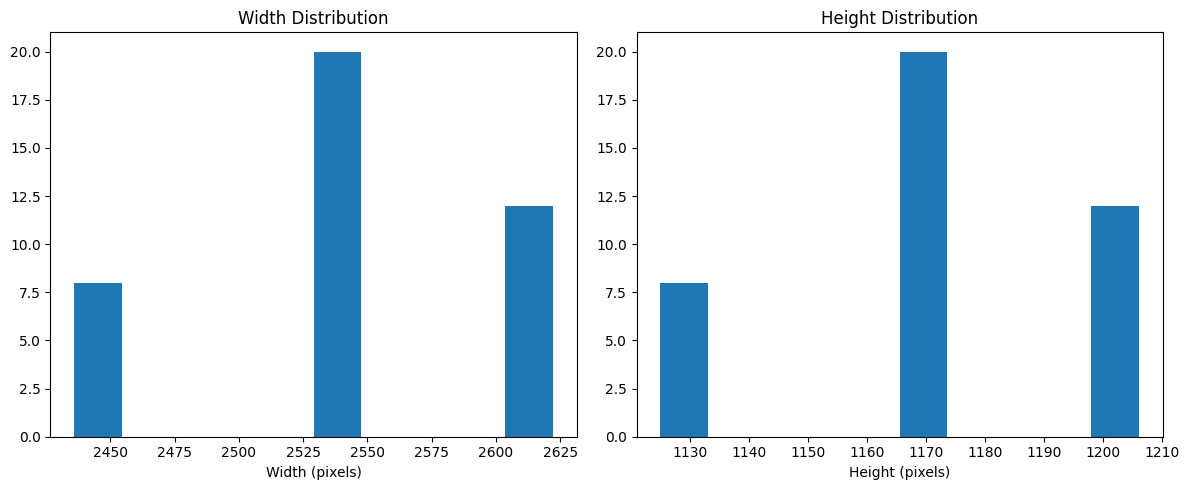

Suggested dimensions: 224x103
Selected image dimensions: (224, 103)


In [10]:
# After analyzing the sample images, define appropriate dimensions
# Note: We'll finalize this once we see the actual image dimensions

def determine_optimal_dimensions(base_dir):
    """
    Analyze a sample of images to determine optimal dimensions for preprocessing
    """
    dimensions = []

    # Sample some images from each class in the training set
    train_dir = os.path.join(base_dir, 'train')
    classes = os.listdir(train_dir)

    for cls in classes:
        class_dir = os.path.join(train_dir, cls)
        images = os.listdir(class_dir)[:5]  # Sample up to 5 images per class

        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path)
            dimensions.append(img.size)

    # Calculate statistics
    widths = [d[0] for d in dimensions]
    heights = [d[1] for d in dimensions]

    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Median: {np.median(widths)}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Median: {np.median(heights)}")

    # Plot dimension distribution
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=10)
    plt.title('Width Distribution')
    plt.xlabel('Width (pixels)')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=10)
    plt.title('Height Distribution')
    plt.xlabel('Height (pixels)')

    plt.tight_layout()
    plt.show()

    # Suggest dimensions based on the median (rounded to nearest multiple of 32)
    median_width = np.median(widths)
    median_height = np.median(heights)

    suggested_width = int(np.ceil(median_width / 32) * 32)
    suggested_height = int(np.ceil(median_height / 32) * 32)

    # If too large, cap at reasonable size
    max_dim = 224  # Standard input size for many pre-trained models

    if suggested_width > max_dim or suggested_height > max_dim:
        aspect_ratio = median_width / median_height
        if aspect_ratio > 1:
            suggested_width = max_dim
            suggested_height = int(max_dim / aspect_ratio)
        else:
            suggested_height = max_dim
            suggested_width = int(max_dim * aspect_ratio)

    print(f"Suggested dimensions: {suggested_width}x{suggested_height}")
    return suggested_width, suggested_height

# Run the analysis to determine optimal dimensions
target_width, target_height = determine_optimal_dimensions(base_dir)

# We'll use these dimensions throughout our project
IMG_SIZE = (target_width, target_height)
print(f"Selected image dimensions: {IMG_SIZE}")

## Data Generators Setup

In [11]:
# Define image dimensions and batch size
IMG_WIDTH, IMG_HEIGHT = 224, 103
BATCH_SIZE = 32

# Define data generators
def create_data_generators(base_dir):
    # Create basic data generators (no augmentation yet)
    train_datagen = ImageDataGenerator(
        rescale=1./255
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255
    )

    # Create generators for each split
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(base_dir, 'validation'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Get class indices to understand the mapping
    class_indices = train_generator.class_indices
    print("Class indices:", class_indices)

    # Number of classes
    num_classes = len(class_indices)
    print(f"Number of classes: {num_classes}")

    return train_generator, validation_generator, test_generator, num_classes

# Create generators
base_dir = "split_clash"  # Using the correct directory name
train_generator, validation_generator, test_generator, num_classes = create_data_generators(base_dir)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE + 1  # Add 1 to ensure all samples are evaluated
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Extract class names for later use
class_names = list(train_generator.class_indices.keys())
print(f"Class names: {class_names}")

Found 721 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 161 images belonging to 8 classes.
Class indices: {'th_10': 0, 'th_11': 1, 'th_12': 2, 'th_13': 3, 'th_14': 4, 'th_15': 5, 'th_16': 6, 'th_17': 7}
Number of classes: 8
Steps per epoch: 22
Validation steps: 6
Class names: ['th_10', 'th_11', 'th_12', 'th_13', 'th_14', 'th_15', 'th_16', 'th_17']


## Baseline CNN Arch

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 103, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 51, 112, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 51, 112, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    11,010,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,403,080 (43.50 MB)

 Trainable params: 11,403,080 (43.50 MB)

 Non-trainable params: 0 (0.00 B)

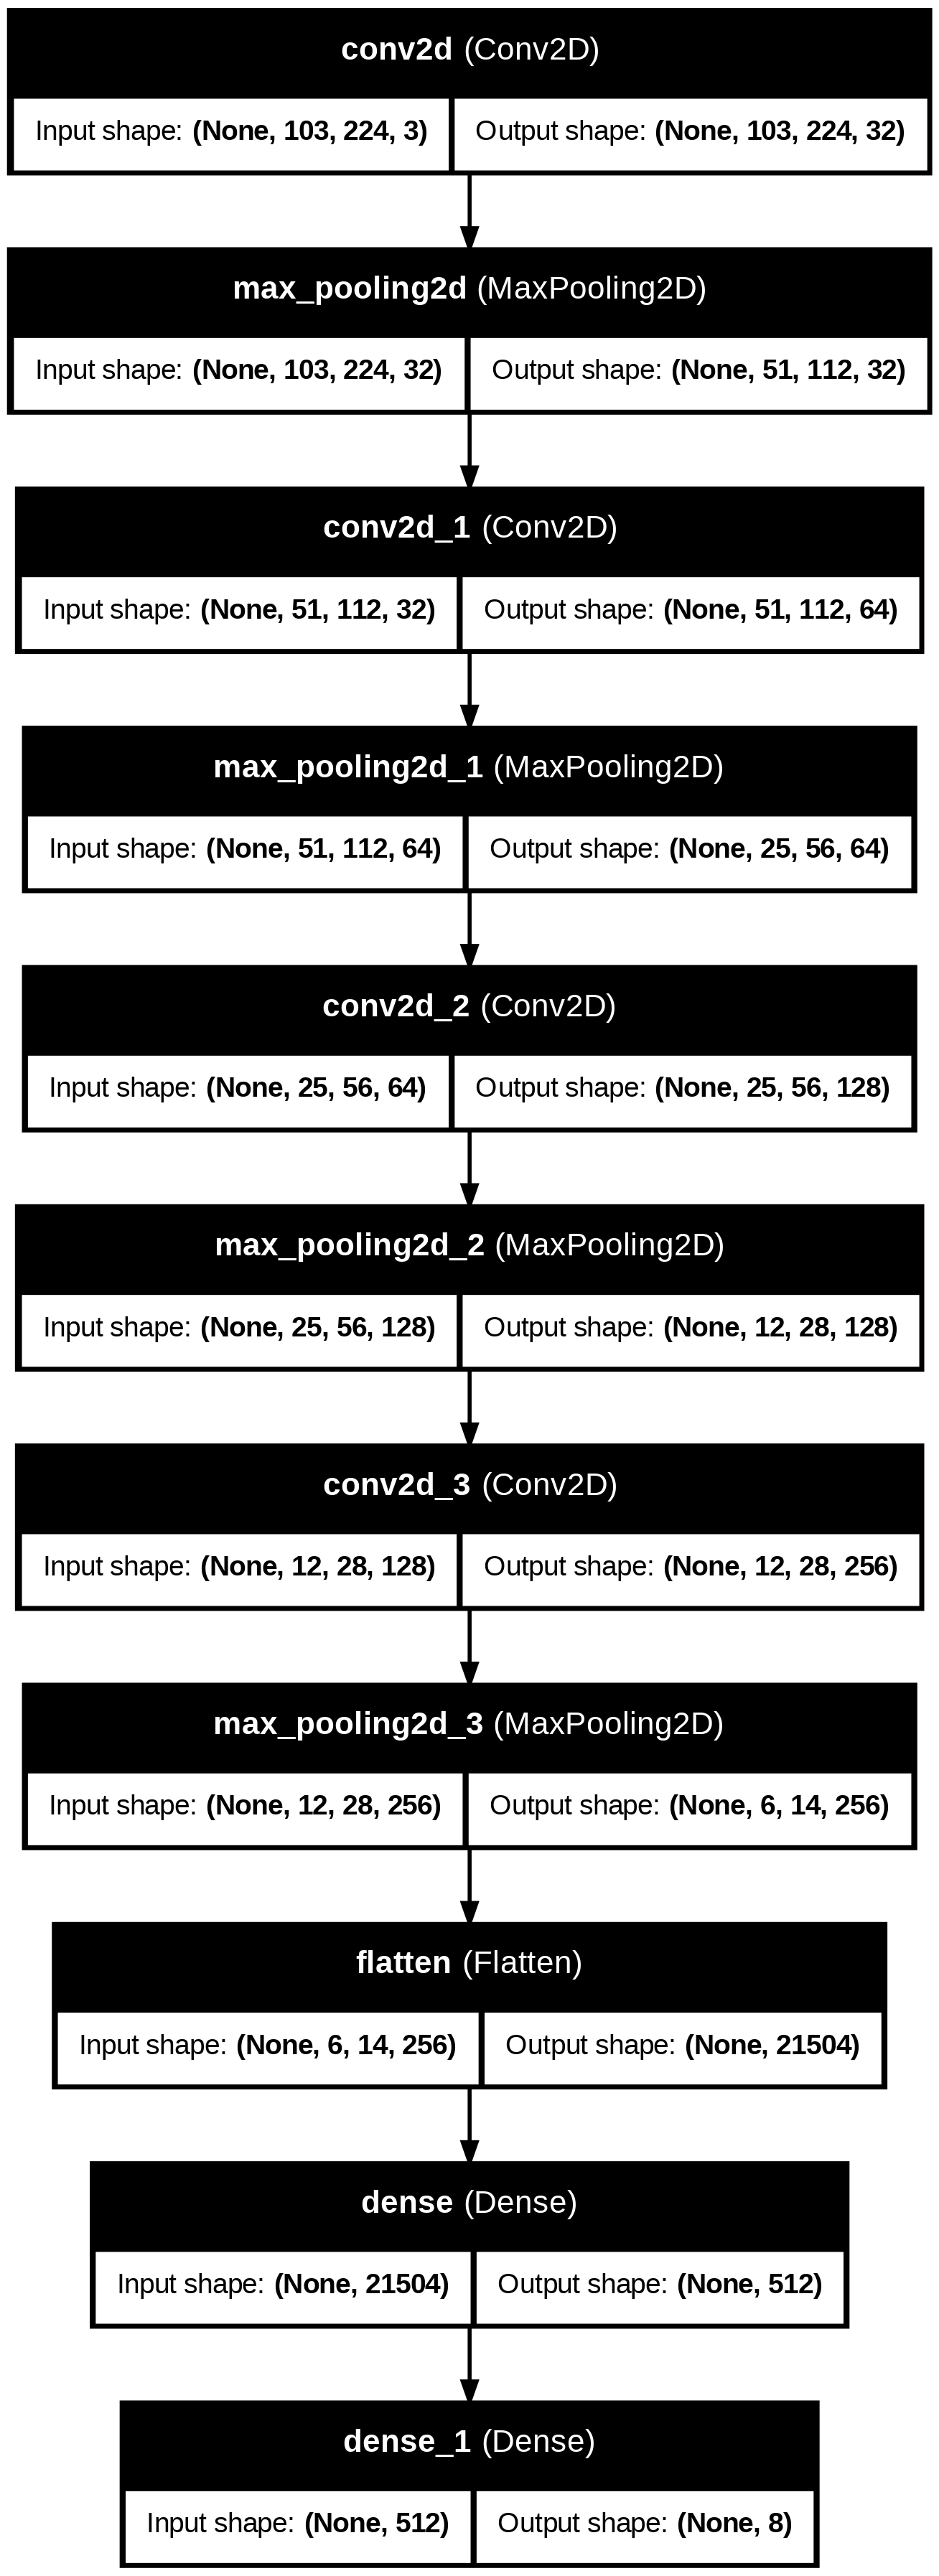

In [12]:
def create_baseline_model(input_shape, num_classes):
    """
    Create a baseline CNN model for the Town Hall classification task
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the baseline model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # Height, Width, Channels
baseline_model = create_baseline_model(input_shape, num_classes)

# Print model summary
baseline_model.summary()

# Visualize the model architecture (optional)
from tensorflow.keras.utils import plot_model
plot_model(baseline_model, to_file='baseline_model.png', show_shapes=True, show_layer_names=True)

## Train Baseline Model

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1644 - loss: 2.1276
Epoch 1: val_accuracy improved from -inf to 0.41250, saving model to model_checkpoints/baseline_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 298s 13s/step - accuracy: 0.1667 - loss: 2.1222 - val_accuracy: 0.4125 - val_loss: 1.5226
Epoch 2/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4062 - loss: 1.4679
Epoch 2: val_accuracy improved from 0.41250 to 0.46875, saving model to model_checkpoints/baseline_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step - accuracy: 0.4062 - loss: 1.4679 - val_accuracy: 0.4688 - val_loss: 1.3766
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4987 - loss: 1.2430
Epoch 3: val_accuracy improved from 0.46875 to 0.51250, saving model to model_checkpoints/baseline_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5009 - loss: 1.2375 - val_accuracy: 0.5125 - val_loss: 1.1320
Epoch 4/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3750 - loss: 1.2923
Epoch 4: val_accuracy improved from 0.51250 to 0.59375, saving model to model_checkpoints/baseline_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 471ms/step - accuracy: 0.3750 - loss: 1.2923 - val_accuracy: 0.5938 - val_loss: 0.8631
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6580 - loss: 0.8595
Epoch 5: val_accuracy improved from 0.59375 to 0.81250, saving model to model_checkpoints/baseline_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6604 - loss: 0.8554 - val_accuracy: 0.8125 - val_loss: 0.4519
Epoch 6/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8750 - loss: 0.4260
Epoch 6: val_accuracy did not improve from 0.81250
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 564ms/step - accuracy: 0.8750 - loss: 0.4260 - val_accuracy: 0.7125 - val_loss: 0.7906
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8020 - loss: 0.4974
Epoch 7: val_accuracy improved from 0.81250 to 0.88750, saving model to model_checkpoints/baseline_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8028 - loss: 0.4974 - val_accuracy: 0.8875 - val_loss: 0.5080
Epoch 8/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9062 - loss: 0.4278
Epoch 8: val_accuracy did not improve from 0.88750
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 564ms/step - accuracy: 0.9062 - loss: 0.4278 - val_accuracy: 0.7250 - val_loss: 0.7963
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7814 - loss: 0.5327
Epoch 9: val_accuracy did not improve from 0.88750
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7817 - loss: 0.5313 - val_accuracy: 0.8375 - val_loss: 0.3678
Epoch 10/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.1343
Epoch 10: val_accuracy did not improve from 0.88750
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 434ms/step - accuracy: 0.9688 - loss: 0.1343 - val_accuracy: 0.8813 - val_loss: 0.3014
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8892 - loss: 0.2732
Epoch 11: val_accuracy did not improve from 0

22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8847 - loss: 0.3129 - val_accuracy: 0.9000 - val_loss: 0.2686
Epoch 14/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.3303
Epoch 14: val_accuracy improved from 0.90000 to 0.91250, saving model to model_checkpoints/baseline_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 467ms/step - accuracy: 0.9688 - loss: 0.3303 - val_accuracy: 0.9125 - val_loss: 0.2630
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9396 - loss: 0.1784
Epoch 15: val_accuracy improved from 0.91250 to 0.93125, saving model to model_checkpoints/baseline_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9400 - loss: 0.1775 - val_accuracy: 0.9312 - val_loss: 0.1915
Epoch 16/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.1031
Epoch 16: val_accuracy did not improve from 0.93125
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.9688 - loss: 0.1031 - val_accuracy: 0.9000 - val_loss: 0.2578
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9339 - loss: 0.1657
Epoch 17: val_accuracy did not improve from 0.93125
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9325 - loss: 0.1699 - val_accuracy: 0.7312 - val_loss: 0.7976
Epoch 18/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8750 - loss: 0.5317
Epoch 18: val_accuracy did not improve from 0.93125
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 433ms/step - accuracy: 0.8750 - loss: 0.5317 - val_accuracy: 0.8313 - val_loss: 0.5752
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8960 - loss: 0.3196
Epoch 19: val_accuracy did not improve fro

22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9462 - loss: 0.1532 - val_accuracy: 0.9688 - val_loss: 0.1087
Epoch 26/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0371
Epoch 26: val_accuracy did not improve from 0.96875
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 439ms/step - accuracy: 0.9688 - loss: 0.0371 - val_accuracy: 0.9688 - val_loss: 0.1050
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9886 - loss: 0.0528
Epoch 27: val_accuracy improved from 0.96875 to 0.97500, saving model to model_checkpoints/baseline_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9888 - loss: 0.0522 - val_accuracy: 0.9750 - val_loss: 0.0816
Epoch 28/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0160
Epoch 28: val_accuracy did not improve from 0.97500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 429ms/step - accuracy: 1.0000 - loss: 0.0160 - val_accuracy: 0.9438 - val_loss: 0.0804
Epoch 29/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9892 - loss: 0.0259
Epoch 29: val_accuracy did not improve from 0.97500
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9895 - loss: 0.0256 - val_accuracy: 0.9625 - val_loss: 0.0927
Epoch 30/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0056
Epoch 30: val_accuracy did not improve from 0.97500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 439ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9625 - val_loss: 0.1011
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9990 - loss: 0.0087
Epoch 31: val_accuracy did not improve fro

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.9688 - loss: 0.0385 - val_accuracy: 0.9875 - val_loss: 0.0889
Epoch 33/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9926 - loss: 0.0203
Epoch 33: val_accuracy did not improve from 0.98750
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9919 - loss: 0.0219 - val_accuracy: 0.9438 - val_loss: 0.1398
Epoch 34/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0347
Epoch 34: val_accuracy did not improve from 0.98750
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.9688 - loss: 0.0347 - val_accuracy: 0.9688 - val_loss: 0.1029
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9831 - loss: 0.0777
Epoch 35: val_accuracy did not improve from 0.98750
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9830 - loss: 0.0781 - val_accuracy: 0.9375 - val_loss: 0.2182
Epoch 36/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.1226
Epoch 36: val_accuracy did not improve f

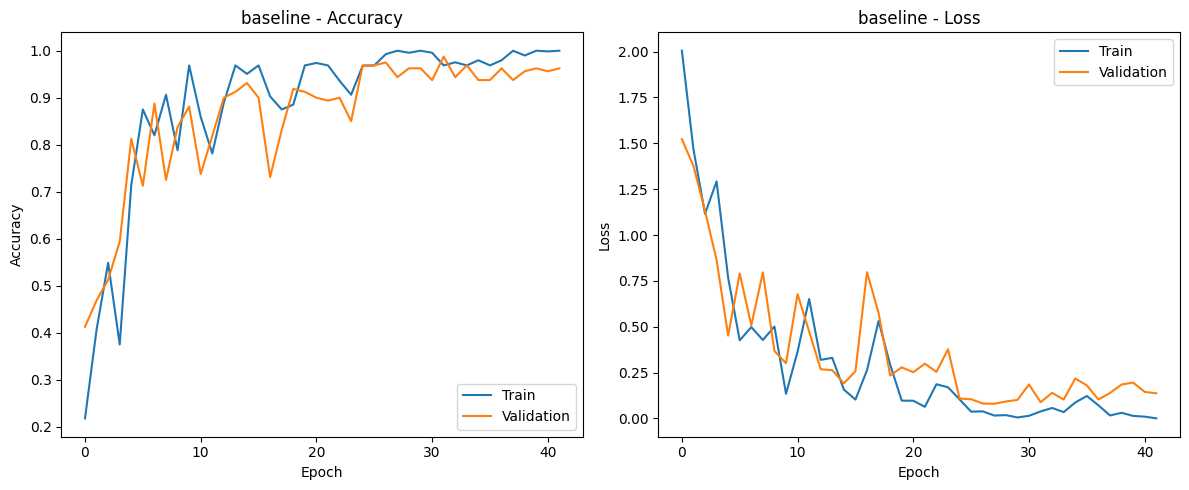

6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.9872 - loss: 0.0500
Test accuracy: 0.9814
Test loss: 0.0688
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


Classification Report:
              precision    recall  f1-score   support

       th_10       1.00      1.00      1.00        20
       th_11       1.00      1.00      1.00        20
       th_12       1.00      0.95      0.97        20
       th_13       1.00      1.00      1.00        20
       th_14       0.95      1.00      0.98        20
       th_15       1.00      1.00      1.00        22
       th_16       0.90      1.00      0.95        18
       th_17       1.00      0.90      0.95        21

    accuracy                           0.98       161
   macro avg       0.98      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



In [13]:
# Create a directory for model checkpoints
checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Setup callbacks
def setup_callbacks(model_name):
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}_best.h5")
    model_checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    return [early_stopping, model_checkpoint]

# Function to plot learning curves
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(f'{model_name}_learning_curves.png')
    plt.show()

# Function to evaluate model on test set
def evaluate_model(model, test_generator):
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Get predictions
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    y_true = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Print classification report
    report = classification_report(y_true, y_pred_classes, target_names=class_names)
    print("Classification Report:")
    print(report)

    return test_acc, y_pred_classes, y_true

# Train the baseline model
def train_model(model, model_name):
    callbacks = setup_callbacks(model_name)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=50,  # Start with a high number, early stopping will prevent overfitting
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    # Plot learning curves
    plot_learning_curves(history, model_name)

    # Evaluate on test set
    test_acc, y_pred_classes, y_true = evaluate_model(model, test_generator)

    return history, test_acc, y_pred_classes, y_true

# Train the baseline model
baseline_history, baseline_test_acc, baseline_y_pred, baseline_y_true = train_model(baseline_model, 'baseline')

## CNN Architecture Experiments


{'='*50}
Training model_v3: Deeper architecture with double conv layers per block


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 103, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 103, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 51, 112, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 51, 112, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 51, 112, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    11,010,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,186,920 (46.49 MB)

 Trainable params: 12,186,920 (46.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1235 - loss: 2.1261
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to model_checkpoints/model_v3_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1234 - loss: 2.1249 - val_accuracy: 0.1250 - val_loss: 2.0792
Epoch 2/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0938 - loss: 2.0802
Epoch 2: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.0938 - loss: 2.0802 - val_accuracy: 0.1250 - val_loss: 2.0792
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1150 - loss: 2.0801
Epoch 3: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.1148 - loss: 2.0801 - val_accuracy: 0.1250 - val_loss: 2.0786
Epoch 4/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0312 - loss: 2.0800
Epoch 4: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 442ms/step - accuracy: 0.0312 - loss: 2.0800 - val_accuracy: 0.1250 - val_loss: 2.0791
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1236 - loss: 2.0786
Epoch 5: val_accuracy improved from 0.12500 to 

22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.1237 - loss: 2.0786 - val_accuracy: 0.1375 - val_loss: 2.0789
Epoch 6/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0588 - loss: 2.0806
Epoch 6: val_accuracy did not improve from 0.13750
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.0588 - loss: 2.0806 - val_accuracy: 0.1375 - val_loss: 2.0789
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1272 - loss: 2.0802
Epoch 7: val_accuracy did not improve from 0.13750
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.1277 - loss: 2.0801 - val_accuracy: 0.1375 - val_loss: 2.0788
Epoch 8/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0938 - loss: 2.0787
Epoch 8: val_accuracy did not improve from 0.13750
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.0938 - loss: 2.0787 - val_accuracy: 0.1375 - val_loss: 2.0788
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1512 - loss: 2.0791
Epoch 9: val_accuracy did not improve from 0.13

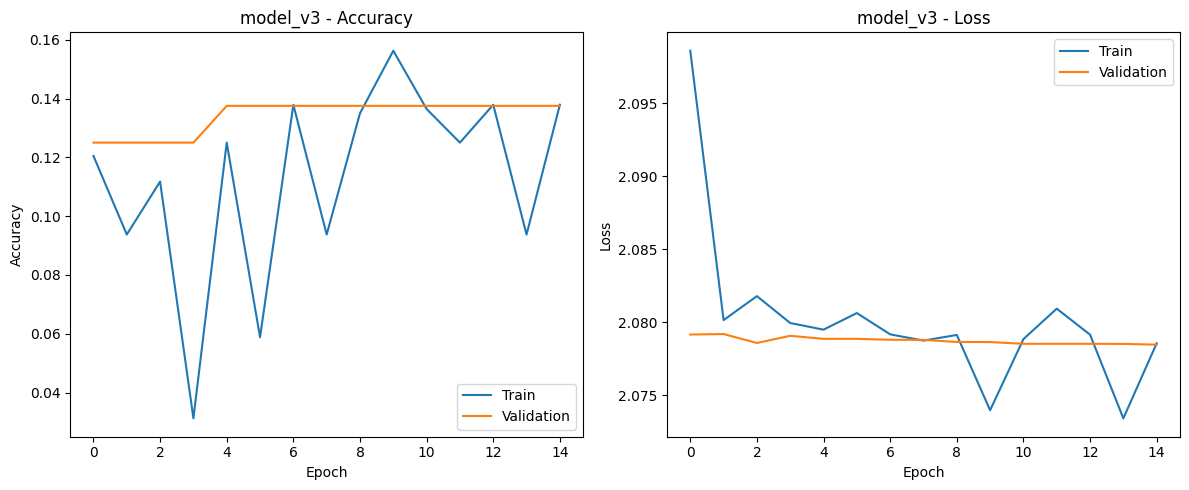

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.0832 - loss: 2.0788
Test accuracy: 0.1366
Test loss: 2.0788
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


Classification Report:
              precision    recall  f1-score   support

       th_10       0.00      0.00      0.00        20
       th_11       0.00      0.00      0.00        20
       th_12       0.00      0.00      0.00        20
       th_13       0.00      0.00      0.00        20
       th_14       0.00      0.00      0.00        20
       th_15       0.14      1.00      0.24        22
       th_16       0.00      0.00      0.00        18
       th_17       0.00      0.00      0.00        21

    accuracy                           0.14       161
   macro avg       0.02      0.12      0.03       161
weighted avg       0.02      0.14      0.03       161



Model Comparison:
Model        Val Acc    Test Acc   Description
--------------------------------------------------------------------------------
baseline     N/A        0.9814     Standard CNN with 4 conv blocks, filter sizes: 32-64-128-256
model_v3     0.1375     0.1366     Deeper architecture with double conv layers per

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Create different CNN architectures to experiment with
def create_model_v2(input_shape, num_classes):
    """
    Second version with more filters
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_model_v3(input_shape, num_classes):
    """
    Third version with deeper architecture (more layers)
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_model_v4(input_shape, num_classes):
    """
    Fourth version with different filter sizes
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Dictionary to store results
model_results = {
    'baseline': {
        'val_accuracy': None,
        'test_accuracy': baseline_test_acc,
        'description': 'Standard CNN with 4 conv blocks, filter sizes: 32-64-128-256'
    }
}

# Train and evaluate additional models
models_to_try = [
    ('model_v2', create_model_v2, 'More filters: 64-128-256-512, dense: 1024'),
    ('model_v3', create_model_v3, 'Deeper architecture with double conv layers per block'),
    ('model_v4', create_model_v4, 'Different filter sizes: 5x5 in early layers, 3x3 in later layers')
]

# Function to train all model variants
def train_all_model_variants():
    for model_name, model_func, description in models_to_try:
        print(f"\n{'='*50}")
        print(f"Training {model_name}: {description}")
        print(f"{'='*50}")

        # Create the model
        model = model_func(input_shape, num_classes)
        model.summary()

        # Train and evaluate
        history, test_acc, _, _ = train_model(model, model_name)

        # Store results
        val_acc = max(history.history['val_accuracy'])
        model_results[model_name] = {
            'val_accuracy': val_acc,
            'test_accuracy': test_acc,
            'description': description
        }

    # Print comparison table
    print("\n\nModel Comparison:")
    print(f"{'Model':<12} {'Val Acc':<10} {'Test Acc':<10} {'Description'}")
    print(f"{'-'*80}")

    for model_name, results in model_results.items():
        val_acc = results['val_accuracy']
        test_acc = results['test_accuracy']
        desc = results['description']

        val_acc_str = f"{val_acc:.4f}" if val_acc is not None else "N/A"
        test_acc_str = f"{test_acc:.4f}" if test_acc is not None else "N/A"

        print(f"{model_name:<12} {val_acc_str:<10} {test_acc_str:<10} {desc}")

    # Find best model
    best_model = max(model_results.items(), key=lambda x: x[1]['test_accuracy'])
    print(f"\nBest model: {best_model[0]} with test accuracy: {best_model[1]['test_accuracy']:.4f}")

    return best_model[0]

# Run the model training experiment - just try model_v3 (deeper architecture)
print("\n{'='*50}")
print(f"Training model_v3: Deeper architecture with double conv layers per block")
print(f"{'='*50}")

# Create the model
model_v3 = create_model_v3(input_shape, num_classes)
model_v3.summary()

# Train and evaluate
history_v3, test_acc_v3, _, _ = train_model(model_v3, 'model_v3')

# Store results
val_acc_v3 = max(history_v3.history['val_accuracy'])
model_results['model_v3'] = {
    'val_accuracy': val_acc_v3,
    'test_accuracy': test_acc_v3,
    'description': 'Deeper architecture with double conv layers per block'
}

# Print comparison table
print("\n\nModel Comparison:")
print(f"{'Model':<12} {'Val Acc':<10} {'Test Acc':<10} {'Description'}")
print(f"{'-'*80}")

for model_name, results in model_results.items():
    val_acc = results['val_accuracy']
    test_acc = results['test_accuracy']
    desc = results['description']

    val_acc_str = f"{val_acc:.4f}" if val_acc is not None else "N/A"
    test_acc_str = f"{test_acc:.4f}" if test_acc is not None else "N/A"

    print(f"{model_name:<12} {val_acc_str:<10} {test_acc_str:<10} {desc}")

# Determine if model_v3 improves over baseline
if test_acc_v3 > baseline_test_acc:
    print(f"\nModel v3 improves over baseline by {(test_acc_v3 - baseline_test_acc)*100:.2f}%")
    best_model_name = 'model_v3'
else:
    print(f"\nModel v3 does not improve over baseline. Staying with baseline model.")
    best_model_name = 'baseline'

## Data Augmentation Implementation


Visualizing basic augmentation:


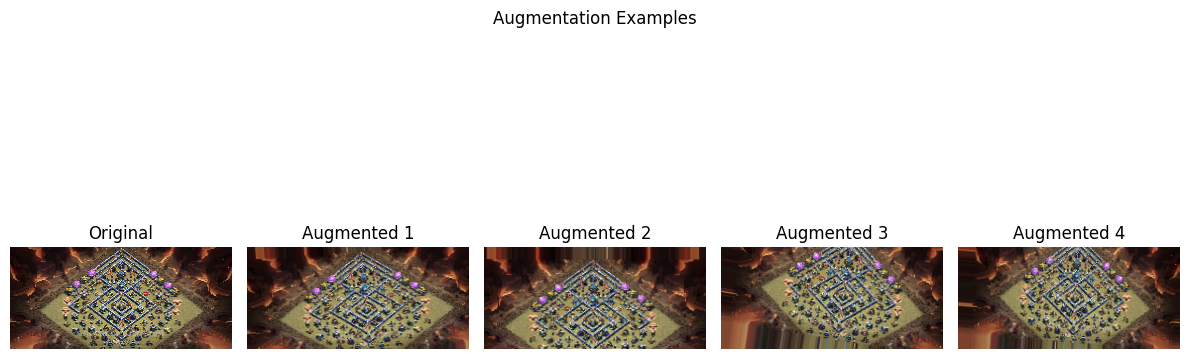


Visualizing moderate augmentation:


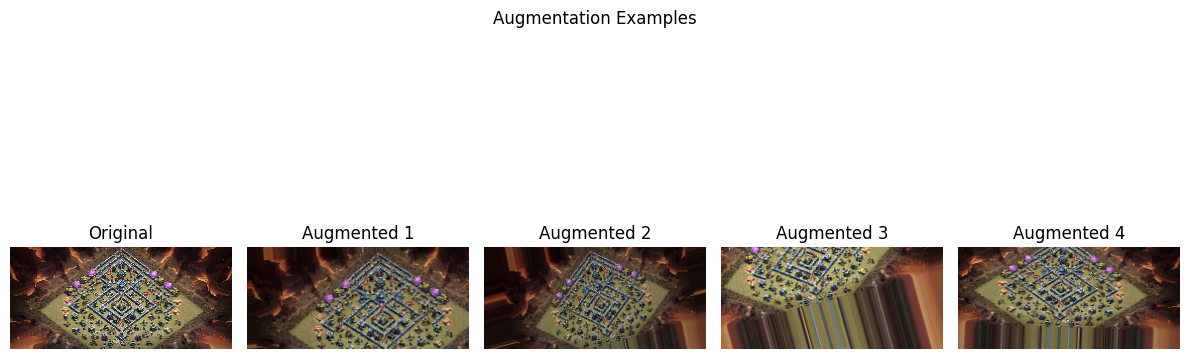


Visualizing aggressive augmentation:



Training with basic augmentation:
Config: {'rotation_range': 10, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'zoom_range': 0.1, 'horizontal_flip': True}
Found 721 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 161 images belonging to 8 classes.
Created augmented generator: basic


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1323 - loss: 2.2138
Epoch 1: val_accuracy improved from -inf to 0.16875, saving model to model_checkpoints/baseline_basic_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1324 - loss: 2.2091 - val_accuracy: 0.1688 - val_loss: 1.8824
Epoch 2/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1250 - loss: 2.0036
Epoch 2: val_accuracy improved from 0.16875 to 0.23125, saving model to model_checkpoints/baseline_basic_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.1250 - loss: 2.0036 - val_accuracy: 0.2313 - val_loss: 1.8199
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2313 - loss: 1.7520
Epoch 3: val_accuracy improved from 0.23125 to 0.25000, saving model to model_checkpoints/baseline_basic_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2330 - loss: 1.7485 - val_accuracy: 0.2500 - val_loss: 1.6179
Epoch 4/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1875 - loss: 1.8481
Epoch 4: val_accuracy improved from 0.25000 to 0.33125, saving model to model_checkpoints/baseline_basic_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 595ms/step - accuracy: 0.1875 - loss: 1.8481 - val_accuracy: 0.3313 - val_loss: 1.5744
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3502 - loss: 1.6603
Epoch 5: val_accuracy improved from 0.33125 to 0.38125, saving model to model_checkpoints/baseline_basic_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.3533 - loss: 1.6531 - val_accuracy: 0.3812 - val_loss: 1.2693
Epoch 6/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6562 - loss: 0.8936
Epoch 6: val_accuracy improved from 0.38125 to 0.43125, saving model to model_checkpoints/baseline_basic_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - accuracy: 0.6562 - loss: 0.8936 - val_accuracy: 0.4313 - val_loss: 1.5594
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5434 - loss: 1.1540
Epoch 7: val_accuracy did not improve from 0.43125
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5433 - loss: 1.1539 - val_accuracy: 0.2125 - val_loss: 2.2650
Epoch 8/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6875 - loss: 1.0881
Epoch 8: val_accuracy did not improve from 0.43125
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.6875 - loss: 1.0881 - val_accuracy: 0.2562 - val_loss: 2.1367
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5674 - loss: 0.9820
Epoch 9: val_accuracy improved from 0.43125 to 0.69375, saving model to model_checkpoints/baseline_basic_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5694 - loss: 0.9777 - val_accuracy: 0.6938 - val_loss: 0.7256
Epoch 10/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6875 - loss: 0.8321
Epoch 10: val_accuracy improved from 0.69375 to 0.70625, saving model to model_checkpoints/baseline_basic_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - accuracy: 0.6875 - loss: 0.8321 - val_accuracy: 0.7063 - val_loss: 0.7432
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6317 - loss: 0.8174
Epoch 11: val_accuracy did not improve from 0.70625
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6329 - loss: 0.8156 - val_accuracy: 0.7000 - val_loss: 0.7911
Epoch 12/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6875 - loss: 0.5780
Epoch 12: val_accuracy did not improve from 0.70625
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.6875 - loss: 0.5780 - val_accuracy: 0.6625 - val_loss: 0.7025
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7248 - loss: 0.6598
Epoch 13: val_accuracy did not improve from 0.70625
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7250 - loss: 0.6584 - val_accuracy: 0.5938 - val_loss: 1.5801
Epoch 14/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8125 - loss: 0.4913
Epoch 14: val_accuracy did not improve f

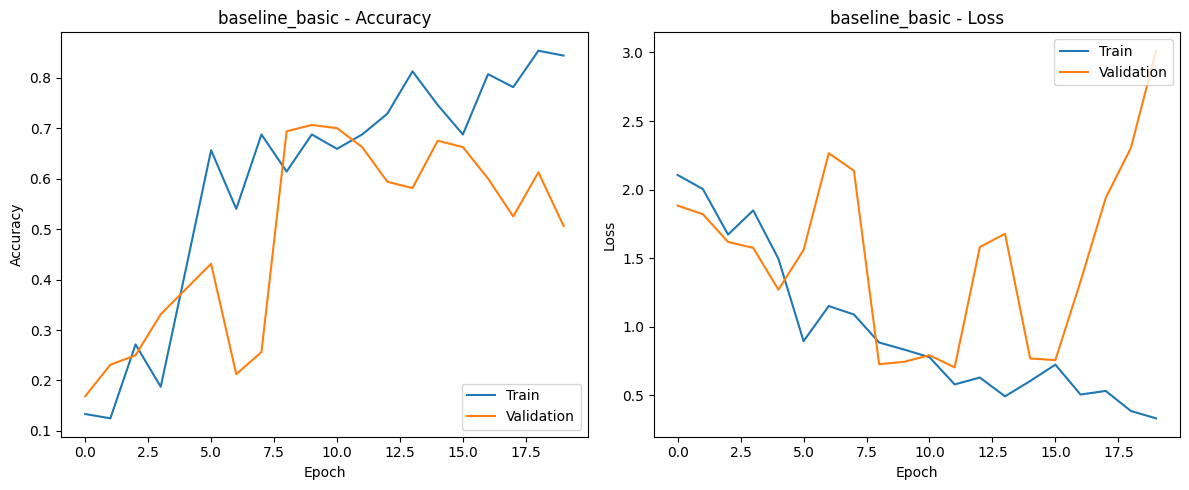

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7197 - loss: 0.6465
Test accuracy with basic augmentation: 0.7329

Training with moderate augmentation:
Config: {'rotation_range': 20, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'zoom_range': 0.2, 'horizontal_flip': True, 'vertical_flip': False, 'brightness_range': [0.8, 1.2]}
Found 721 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 161 images belonging to 8 classes.
Created augmented generator: moderate
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1134 - loss: 2.1127
Epoch 1: val_accuracy improved from -inf to 0.22500, saving model to model_checkpoints/baseline_moderate_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.1136 - loss: 2.1119 - val_accuracy: 0.2250 - val_loss: 2.0370
Epoch 2/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0625 - loss: 2.0654
Epoch 2: val_accuracy did not improve from 0.22500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - accuracy: 0.0625 - loss: 2.0654 - val_accuracy: 0.2250 - val_loss: 2.0165
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1649 - loss: 2.0046
Epoch 3: val_accuracy did not improve from 0.22500
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.1657 - loss: 2.0023 - val_accuracy: 0.1375 - val_loss: 2.0123
Epoch 4/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1562 - loss: 1.7703
Epoch 4: val_accuracy improved from 0.22500 to 0.23750, saving model to model_checkpoints/baseline_moderate_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 524ms/step - accuracy: 0.1562 - loss: 1.7703 - val_accuracy: 0.2375 - val_loss: 1.6578
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2549 - loss: 1.6866
Epoch 5: val_accuracy improved from 0.23750 to 0.30625, saving model to model_checkpoints/baseline_moderate_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2545 - loss: 1.6881 - val_accuracy: 0.3063 - val_loss: 1.5660
Epoch 6/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0938 - loss: 1.6941
Epoch 6: val_accuracy did not improve from 0.30625
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 422ms/step - accuracy: 0.0938 - loss: 1.6941 - val_accuracy: 0.2188 - val_loss: 1.5761
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2812 - loss: 1.5599
Epoch 7: val_accuracy did not improve from 0.30625
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.2822 - loss: 1.5594 - val_accuracy: 0.2062 - val_loss: 2.5094
Epoch 8/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4375 - loss: 1.3699
Epoch 8: val_accuracy improved from 0.30625 to 0.36250, saving model to model_checkpoints/baseline_moderate_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.4375 - loss: 1.3699 - val_accuracy: 0.3625 - val_loss: 2.0725
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4571 - loss: 1.2931
Epoch 9: val_accuracy did not improve from 0.36250
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4558 - loss: 1.2941 - val_accuracy: 0.2500 - val_loss: 2.9051
Epoch 10/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4062 - loss: 1.1454
Epoch 10: val_accuracy did not improve from 0.36250
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.4062 - loss: 1.1454 - val_accuracy: 0.1750 - val_loss: 4.7767
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4321 - loss: 1.3103
Epoch 11: val_accuracy did not improve from 0.36250
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4321 - loss: 1.3103 - val_accuracy: 0.3562 - val_loss: 1.6350
Epoch 12/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3125 - loss: 1.2344
Epoch 12: val_accuracy did not improve fr

22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5227 - loss: 1.0275 - val_accuracy: 0.5312 - val_loss: 1.2207
Epoch 18/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5000 - loss: 1.0687
Epoch 18: val_accuracy did not improve from 0.53125
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 446ms/step - accuracy: 0.5000 - loss: 1.0687 - val_accuracy: 0.5125 - val_loss: 1.1153
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5648 - loss: 1.0294
Epoch 19: val_accuracy did not improve from 0.53125
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5648 - loss: 1.0287 - val_accuracy: 0.4187 - val_loss: 1.2529
Epoch 20/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5000 - loss: 0.9544
Epoch 20: val_accuracy did not improve from 0.53125
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 423ms/step - accuracy: 0.5000 - loss: 0.9544 - val_accuracy: 0.3438 - val_loss: 1.8937
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5912 - loss: 0.9510
Epoch 21: val_accuracy did not improve fro

22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6160 - loss: 0.8889 - val_accuracy: 0.6562 - val_loss: 0.7887
Epoch 24/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7188 - loss: 0.7293
Epoch 24: val_accuracy did not improve from 0.65625
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - accuracy: 0.7188 - loss: 0.7293 - val_accuracy: 0.5188 - val_loss: 1.0516
Epoch 25/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6020 - loss: 0.9375
Epoch 25: val_accuracy did not improve from 0.65625
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6025 - loss: 0.9363 - val_accuracy: 0.3313 - val_loss: 2.0324
Epoch 26/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5625 - loss: 0.8778
Epoch 26: val_accuracy did not improve from 0.65625
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 436ms/step - accuracy: 0.5625 - loss: 0.8778 - val_accuracy: 0.4187 - val_loss: 1.4855
Epoch 27/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6597 - loss: 0.7980
Epoch 27: val_accuracy did not improve fr

22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7026 - loss: 0.7233 - val_accuracy: 0.6812 - val_loss: 1.2498
Epoch 34/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7812 - loss: 0.4762
Epoch 34: val_accuracy did not improve from 0.68125
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 438ms/step - accuracy: 0.7812 - loss: 0.4762 - val_accuracy: 0.6812 - val_loss: 1.1852
Epoch 35/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7241 - loss: 0.6112
Epoch 35: val_accuracy did not improve from 0.68125
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7243 - loss: 0.6122 - val_accuracy: 0.5250 - val_loss: 1.8640
Epoch 36/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7812 - loss: 0.5390
Epoch 36: val_accuracy did not improve from 0.68125
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 425ms/step - accuracy: 0.7812 - loss: 0.5390 - val_accuracy: 0.6313 - val_loss: 1.6129
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7759 - loss: 0.5069
Epoch 37: val_accuracy did not improve fro

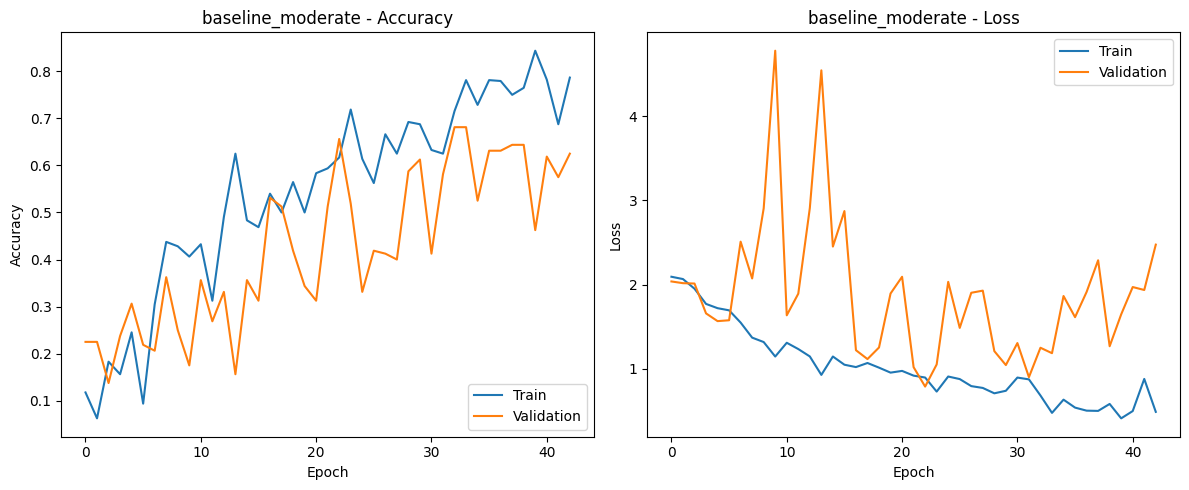

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6302 - loss: 1.4143
Test accuracy with moderate augmentation: 0.7081

Training with aggressive augmentation:
Config: {'rotation_range': 30, 'width_shift_range': 0.3, 'height_shift_range': 0.3, 'zoom_range': 0.3, 'horizontal_flip': True, 'vertical_flip': True, 'brightness_range': [0.7, 1.3], 'shear_range': 0.2, 'fill_mode': 'nearest'}
Found 721 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 161 images belonging to 8 classes.
Created augmented generator: aggressive
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0818 - loss: 2.1696
Epoch 1: val_accuracy improved from -inf to 0.13750, saving model to model_checkpoints/baseline_aggressive_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.0825 - loss: 2.1671 - val_accuracy: 0.1375 - val_loss: 2.0692
Epoch 2/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1875 - loss: 2.0833
Epoch 2: val_accuracy did not improve from 0.13750
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 436ms/step - accuracy: 0.1875 - loss: 2.0833 - val_accuracy: 0.1375 - val_loss: 2.0641
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1507 - loss: 2.0285
Epoch 3: val_accuracy improved from 0.13750 to 0.18750, saving model to model_checkpoints/baseline_aggressive_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.1521 - loss: 2.0262 - val_accuracy: 0.1875 - val_loss: 1.8097
Epoch 4/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3125 - loss: 1.7392
Epoch 4: val_accuracy improved from 0.18750 to 0.45000, saving model to model_checkpoints/baseline_aggressive_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.3125 - loss: 1.7392 - val_accuracy: 0.4500 - val_loss: 1.4313
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2801 - loss: 1.6989
Epoch 5: val_accuracy improved from 0.45000 to 0.55000, saving model to model_checkpoints/baseline_aggressive_best.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.2817 - loss: 1.6954 - val_accuracy: 0.5500 - val_loss: 1.0215
Epoch 6/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4688 - loss: 1.3706
Epoch 6: val_accuracy did not improve from 0.55000
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 573ms/step - accuracy: 0.4688 - loss: 1.3706 - val_accuracy: 0.4187 - val_loss: 1.1648
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4584 - loss: 1.2849
Epoch 7: val_accuracy did not improve from 0.55000
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4574 - loss: 1.2858 - val_accuracy: 0.4000 - val_loss: 1.5164
Epoch 8/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5312 - loss: 1.2273
Epoch 8: val_accuracy did not improve from 0.55000
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 435ms/step - accuracy: 0.5312 - loss: 1.2273 - val_accuracy: 0.3562 - val_loss: 1.7794
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4760 - loss: 1.2226
Epoch 9: val_accuracy did not improve from 0.550

22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.4375 - loss: 1.2979 - val_accuracy: 0.5688 - val_loss: 1.1117
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5462 - loss: 1.0738
Epoch 11: val_accuracy did not improve from 0.56875
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5455 - loss: 1.0743 - val_accuracy: 0.4000 - val_loss: 1.2565
Epoch 12/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6875 - loss: 0.8853
Epoch 12: val_accuracy did not improve from 0.56875
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step - accuracy: 0.6875 - loss: 0.8853 - val_accuracy: 0.3438 - val_loss: 1.8865
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5928 - loss: 0.9961
Epoch 13: val_accuracy did not improve from 0.56875
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5912 - loss: 0.9980 - val_accuracy: 0.5000 - val_loss: 1.5101
Epoch 14/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5000 - loss: 1.1612
Epoch 14: val_accuracy did not improve fr

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 507ms/step - accuracy: 0.4688 - loss: 1.0416 - val_accuracy: 0.6625 - val_loss: 0.8198
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5818 - loss: 0.9643
Epoch 19: val_accuracy did not improve from 0.66250
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5824 - loss: 0.9642 - val_accuracy: 0.4250 - val_loss: 1.6131
Epoch 20/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5938 - loss: 1.0882
Epoch 20: val_accuracy did not improve from 0.66250
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - accuracy: 0.5938 - loss: 1.0882 - val_accuracy: 0.4500 - val_loss: 1.6330
Epoch 21/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6719 - loss: 0.8471
Epoch 21: val_accuracy did not improve from 0.66250
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6707 - loss: 0.8481 - val_accuracy: 0.3875 - val_loss: 1.8531
Epoch 22/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5938 - loss: 1.1434
Epoch 22: val_accuracy did not improve f

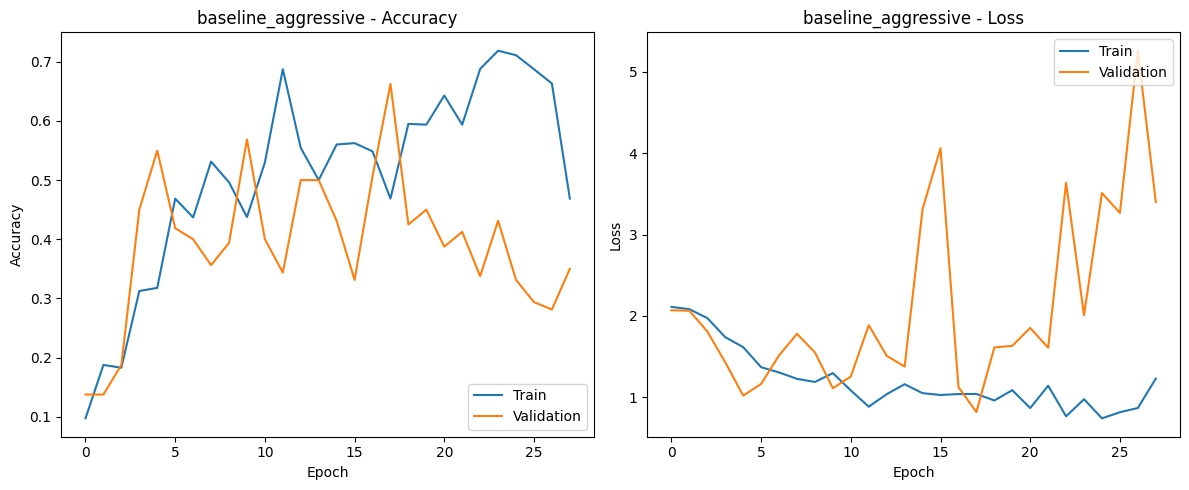

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7233 - loss: 0.7591
Test accuracy with aggressive augmentation: 0.6832


Augmentation Comparison for baseline
Config       Val Acc    Test Acc  
----------------------------------------


TypeError: unsupported format string passed to NoneType.__format__

In [15]:
# Define various data augmentation configurations to experiment with
def create_augmented_generator(base_dir, aug_config, name):
    """
    Create a data generator with specific augmentation settings
    """
    # Create training data generator with augmentations
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        **aug_config
    )

    # Validation and test generators remain the same (no augmentation)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_directory(
        os.path.join(base_dir, 'validation'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    print(f"Created augmented generator: {name}")
    return train_generator, validation_generator, test_generator

# Define augmentation configurations to test
augmentation_configs = {
    'basic': {
        'rotation_range': 10,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
        'zoom_range': 0.1,
        'horizontal_flip': True
    },
    'moderate': {
        'rotation_range': 20,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'zoom_range': 0.2,
        'horizontal_flip': True,
        'vertical_flip': False,
        'brightness_range': [0.8, 1.2]
    },
    'aggressive': {
        'rotation_range': 30,
        'width_shift_range': 0.3,
        'height_shift_range': 0.3,
        'zoom_range': 0.3,
        'horizontal_flip': True,
        'vertical_flip': True,
        'brightness_range': [0.7, 1.3],
        'shear_range': 0.2,
        'fill_mode': 'nearest'
    }
}

# Function to train with different augmentation configurations
def train_with_augmentations(model_func, model_name, base_model_results):
    """
    Train the model with different augmentation configurations
    """
    augmentation_results = {
        'no_aug': base_model_results  # Include baseline without augmentation for comparison
    }

    for aug_name, aug_config in augmentation_configs.items():
        print(f"\n{'='*50}")
        print(f"Training with {aug_name} augmentation:")
        print(f"Config: {aug_config}")
        print(f"{'='*50}")

        # Create data generators with this augmentation
        aug_train_gen, aug_val_gen, aug_test_gen = create_augmented_generator(
            base_dir, aug_config, aug_name
        )

        # Create a fresh model
        model = model_func(input_shape, num_classes)

        # Setup callbacks
        callbacks = setup_callbacks(f"{model_name}_{aug_name}")

        # Train model
        history = model.fit(
            aug_train_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=50,  # Early stopping will prevent overfitting
            validation_data=aug_val_gen,
            validation_steps=validation_steps,
            callbacks=callbacks,
            verbose=1
        )

        # Plot learning curves
        plot_learning_curves(history, f"{model_name}_{aug_name}")

        # Evaluate on test set
        test_loss, test_acc = model.evaluate(aug_test_gen)
        print(f"Test accuracy with {aug_name} augmentation: {test_acc:.4f}")

        # Store results
        val_acc = max(history.history['val_accuracy'])
        augmentation_results[aug_name] = {
            'val_accuracy': val_acc,
            'test_accuracy': test_acc,
            'config': aug_config
        }

    # Create a comparison table
    print("\n\nAugmentation Comparison for", model_name)
    print(f"{'Config':<12} {'Val Acc':<10} {'Test Acc':<10}")
    print(f"{'-'*40}")

    for aug_name, results in augmentation_results.items():
        val_acc = results['val_accuracy']
        test_acc = results['test_accuracy']
        print(f"{aug_name:<12} {val_acc:.4f} {test_acc:.4f}")

    # Find best augmentation
    best_aug = max(augmentation_results.items(), key=lambda x: x[1]['test_accuracy'])
    print(f"\nBest augmentation: {best_aug[0]} with test accuracy: {best_aug[1]['test_accuracy']:.4f}")

    # Compare with base model
    base_acc = base_model_results['test_accuracy']
    improvement = (best_aug[1]['test_accuracy'] - base_acc) * 100
    print(f"Improvement over base model: {improvement:.2f}%")

    return best_aug[0], best_aug[1]['test_accuracy'], augmentation_results

# Function to visualize augmented samples
def visualize_augmentations(aug_config):
    # Set up a figure to display original and augmented images
    plt.figure(figsize=(12, 6))

    # Create an augmentation generator for a single image
    datagen = ImageDataGenerator(**aug_config)

    # Get a sample image from the training set
    train_dir = os.path.join(base_dir, 'train')
    classes = os.listdir(train_dir)
    sample_class = classes[0]  # Use first class
    class_dir = os.path.join(train_dir, sample_class)
    sample_img_name = os.listdir(class_dir)[0]  # Use first image
    sample_img_path = os.path.join(class_dir, sample_img_name)

    # Load the image
    img = load_img(sample_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Display original image
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')

    # Generate and display augmented images
    i = 0
    for batch in datagen.flow(x, batch_size=1):
        plt.subplot(1, 5, i+2)
        plt.imshow(batch[0].astype('uint8'))
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
        i += 1
        if i >= 4:  # Show 4 augmented examples
            break

    plt.tight_layout()
    plt.suptitle(f"Augmentation Examples")
    plt.show()

# This function will be called after we determine the best architecture
def run_data_augmentation(best_model_func, best_model_name, base_model_results):
    """
    Run data augmentation experiments with the best model architecture
    """
    # First, visualize the different augmentation strategies
    for aug_name, aug_config in augmentation_configs.items():
        print(f"\nVisualizing {aug_name} augmentation:")
        visualize_augmentations(aug_config)

    # Then train with each augmentation strategy
    best_aug, best_aug_acc, aug_results = train_with_augmentations(
        best_model_func, best_model_name, base_model_results
    )

    return best_aug, best_aug_acc, aug_results

# This will be used after determining the best model architecture
run_data_augmentation(create_baseline_model, 'baseline', model_results['baseline'])

## Batch Norm

In [16]:
def create_improved_model(input_shape, num_classes):
    """
    Improved CNN based on the successful baseline with added batch normalization
    and slight regularization
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),  # Add dropout only before final layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6332 - loss: 1.2390
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to model_checkpoints/improved_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6400 - loss: 1.2144 - val_accuracy: 0.1250 - val_loss: 6.0096
Epoch 2/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0370
Epoch 2: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 1.0000 - loss: 0.0370 - val_accuracy: 0.1250 - val_loss: 6.2834
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9842 - loss: 0.0745
Epoch 3: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9842 - loss: 0.0743 - val_accuracy: 0.1250 - val_loss: 9.4697
Epoch 4/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0249
Epoch 4: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step - accuracy: 1.0000 - loss: 0.0249 - val_accuracy: 0.1250 - val_loss: 9.5664
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9923 - loss: 0.0340
Epoch 5: val_accuracy did not improve from 0.12

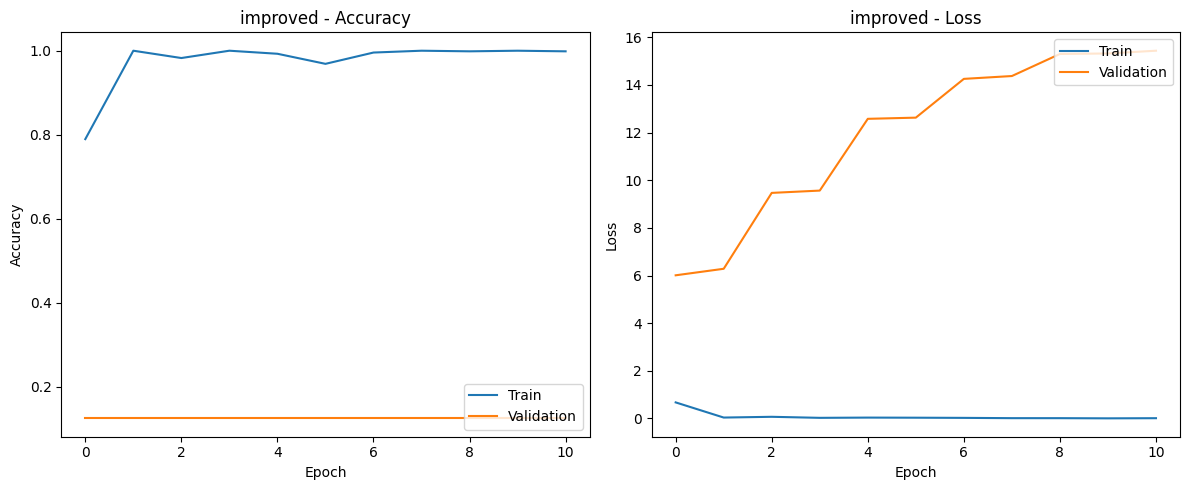

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2394 - loss: 4.6008
Test accuracy: 0.1242
Test loss: 6.0312


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


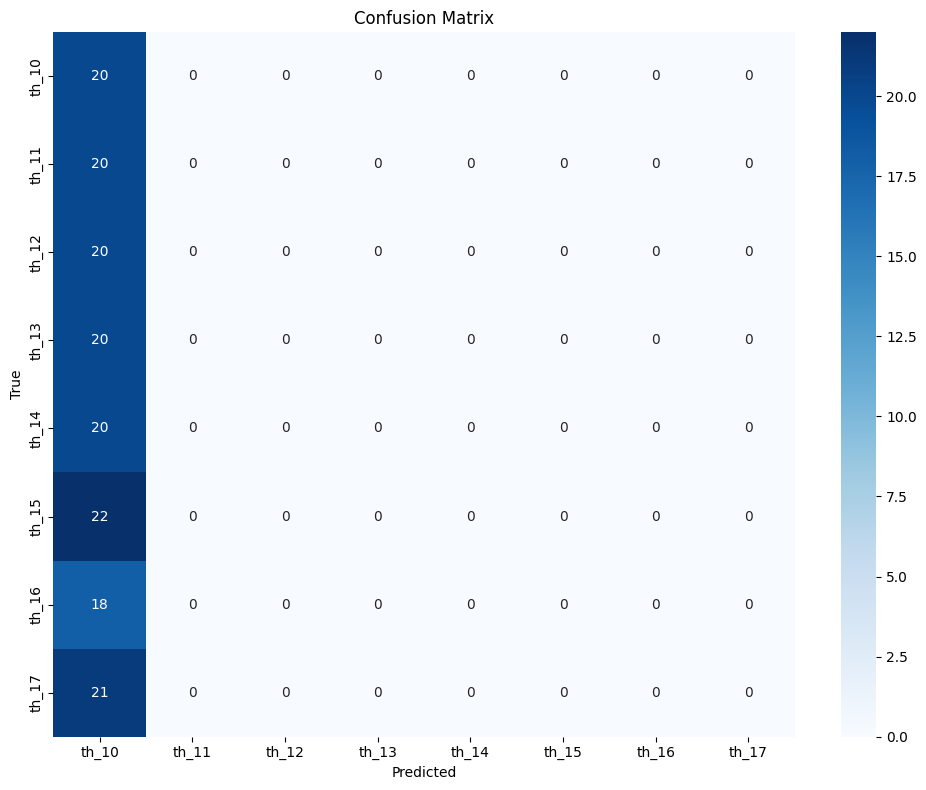

Classification Report:
              precision    recall  f1-score   support

       th_10       0.12      1.00      0.22        20
       th_11       0.00      0.00      0.00        20
       th_12       0.00      0.00      0.00        20
       th_13       0.00      0.00      0.00        20
       th_14       0.00      0.00      0.00        20
       th_15       0.00      0.00      0.00        22
       th_16       0.00      0.00      0.00        18
       th_17       0.00      0.00      0.00        21

    accuracy                           0.12       161
   macro avg       0.02      0.12      0.03       161
weighted avg       0.02      0.12      0.03       161



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
improved_model = create_improved_model(input_shape=(103,224,3), num_classes=8)
# Train the batch
baseline_history, baseline_test_acc, baseline_y_pred, baseline_y_true = train_model(improved_model, 'improved')

## Regularized model

In [18]:
def create_regularized_model(input_shape, num_classes):
    """
    Regularized CNN that prevents overfitting on the Clash of Clans dataset
    """
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),  # Light dropout after each block

        # Second convolutional block
        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),

        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),  # Heavy dropout before final classification
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model with a lower learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Reduced learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5151 - loss: 2.7625
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to model_checkpoints/regularized_best.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5212 - loss: 2.7444 - val_accuracy: 0.1250 - val_loss: 7.3734
Epoch 2/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8438 - loss: 1.8718
Epoch 2: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.8438 - loss: 1.8718 - val_accuracy: 0.1250 - val_loss: 7.6905
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9079 - loss: 1.6603
Epoch 3: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9086 - loss: 1.6590 - val_accuracy: 0.1250 - val_loss: 12.3953
Epoch 4/50
 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9062 - loss: 1.5929
Epoch 4: val_accuracy did not improve from 0.12500
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.9062 - loss: 1.5929 - val_accuracy: 0.1250 - val_loss: 12.6197
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9621 - loss: 1.4977
Epoch 5: val_accuracy did not improve from 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2394 - loss: 6.4660
Test accuracy: 0.1242
Test loss: 7.3939


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


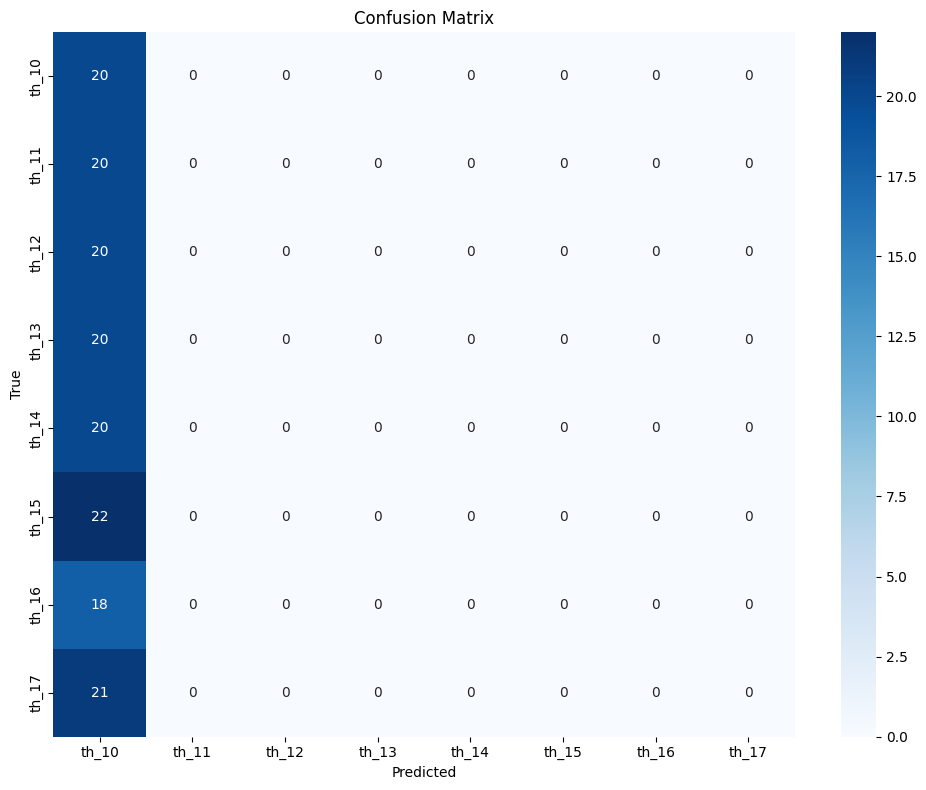

Classification Report:
              precision    recall  f1-score   support

       th_10       0.12      1.00      0.22        20
       th_11       0.00      0.00      0.00        20
       th_12       0.00      0.00      0.00        20
       th_13       0.00      0.00      0.00        20
       th_14       0.00      0.00      0.00        20
       th_15       0.00      0.00      0.00        22
       th_16       0.00      0.00      0.00        18
       th_17       0.00      0.00      0.00        21

    accuracy                           0.12       161
   macro avg       0.02      0.12      0.03       161
weighted avg       0.02      0.12      0.03       161



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
reg_model = create_regularized_model(input_shape=(103,224,3), num_classes=8)
# Train the batch
baseline_history, baseline_test_acc, baseline_y_pred, baseline_y_true = train_model(reg_model, 'regularized')

## Stop and check data says Mr Claude due to massive overfitting with batch norm

In [20]:
# Check class distribution in train and validation sets
def analyze_data_split(train_ds, val_ds, class_names):
    train_counts = {class_name: 0 for class_name in class_names}
    val_counts = {class_name: 0 for class_name in class_names}

    # Count samples in training set
    for images, labels in train_ds:
        for label in labels:
            label_idx = tf.argmax(label).numpy()
            train_counts[class_names[label_idx]] += 1

    # Count samples in validation set
    for images, labels in val_ds:
        for label in labels:
            label_idx = tf.argmax(label).numpy()
            val_counts[class_names[label_idx]] += 1

    # Print results
    print("Class distribution in training set:")
    for class_name, count in train_counts.items():
        print(f"{class_name}: {count}")

    print("\nClass distribution in validation set:")
    for class_name, count in val_counts.items():
        print(f"{class_name}: {count}")

    return train_counts, val_counts

## Transfer Model

In [23]:
# Define the transfer learning model
def create_transfer_model(input_shape, num_classes):
    """
    Transfer learning model using MobileNetV2 that respects the dataset's dimensions
    """
    # Create the base model
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create model with lightweight head
    model = keras.Sequential([
        # Preprocessing layer specifically for MobileNetV2
        keras.layers.Rescaling(1./127.5, offset=-1, input_shape=input_shape),

        # Base model
        base_model,

        # Classification head with regularization
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model with a conservative learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Training function
def train_transfer_model():
    # Create the model
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    transfer_model = create_transfer_model(input_shape, num_classes)

    # Print model summary
    transfer_model.summary()

    # Define callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = transfer_model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )

    # Evaluate the model
    print("\nEvaluating on validation data:")
    val_loss, val_acc = transfer_model.evaluate(validation_generator)
    print(f"Validation accuracy: {val_acc:.4f}")

    print("\nEvaluating on test data:")
    test_loss, test_acc = transfer_model.evaluate(test_generator)
    print(f"Test accuracy: {test_acc:.4f}")

    return transfer_model, history

# Call the function to train and evaluate the transfer learning model
transfer_model, history = train_transfer_model()

<ipython-input-23-725c173cb29d>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 103, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,496 (9.24 MB)

 Trainable params: 165,256 (645.53 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.2754 - loss: 1.8546 - val_accuracy: 0.1500 - val_loss: 2.3549
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.7188 - loss: 1.0714 - val_accuracy: 0.1250 - val_loss: 2.3567
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6528 - loss: 1.0991 - val_accuracy: 0.1250 - val_loss: 2.4446
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.5882 - loss: 0.9606 - val_accuracy: 0.1250 - val_loss: 2.4497
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7147 - loss: 0.8884 - val_accuracy: 0.1250 - val_loss: 2.4683
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 439ms/step - accuracy: 0.7812 - loss: 0.7573 - val_accuracy: 0.1250 - val_loss: 2.4654

Evaluating on validation data:
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1090 - loss: 2.6852
Validation accuracy: 0.1500

Evaluating on test data:
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.1108 - loss: 2.6382
Test accuracy: 0.1429


## Claude losing context
- at this point claude has lost memory that we've already checked data to start
- it forgets that it was claude who determined the input size and in chat has now questioned why the input size was done this way. I reminded it that it did this

In [24]:
def visualize_dataset_samples():
    """
    Visualize sample images from training and validation sets to spot potential issues
    """
    # Reset generators to ensure we get fresh batches
    train_generator.reset()
    validation_generator.reset()

    # Get batches
    train_batch = next(train_generator)
    val_batch = next(validation_generator)

    # Extract images and labels
    train_images, train_labels = train_batch
    val_images, val_labels = val_batch

    # Display images
    plt.figure(figsize=(10, 8))

    for i in range(min(4, len(train_images))):
        plt.subplot(2, 4, i+1)
        plt.imshow(train_images[i])
        class_idx = np.argmax(train_labels[i])
        plt.title(f"Train: {class_names[class_idx]}")
        plt.axis('off')

    for i in range(min(4, len(val_images))):
        plt.subplot(2, 4, i+5)
        plt.imshow(val_images[i])
        class_idx = np.argmax(val_labels[i])
        plt.title(f"Val: {class_names[class_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_dataset_samples()

In [26]:
# Re-evaluate the baseline model on validation data
def evaluate_baseline():
    # Recreate the baseline model
    input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
    baseline_model = create_baseline_model(input_shape, num_classes)

    # Load weights if available, or train from scratch if needed
    try:
        baseline_model.load_weights('./model_checkpoints/baseline_best.h5')
        print("Loaded saved baseline model weights")
    except:
        print("No saved weights found, training baseline model from scratch")
        # Define callbacks
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # Train the model
        baseline_model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=[early_stopping]
        )

    # Evaluate
    print("\nEvaluating baseline on validation data:")
    val_loss, val_acc = baseline_model.evaluate(validation_generator)
    print(f"Validation accuracy: {val_acc:.4f}")

    print("\nEvaluating baseline on test data:")
    test_loss, test_acc = baseline_model.evaluate(test_generator)
    print(f"Test accuracy: {test_acc:.4f}")

    return baseline_model

# Run baseline evaluation
baseline_model = evaluate_baseline()

Loaded saved baseline model weights

Evaluating baseline on validation data:
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9872 - loss: 0.1015
Validation accuracy: 0.9875

Evaluating baseline on test data:
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9872 - loss: 0.0500
Test accuracy: 0.9814
